In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from utils import label_map_util
from utils import visualization_utils as vis_util
import cv2
import os

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
MODEL_NAME = 'checkpoint'
PATH_TO_CKPT = os.path.join(MODEL_NAME, 'frozen_inference_graph.pb')
PATH_TO_LABELS = 'object-detection.pbtxt'
NUM_CLASSES = 1

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
        object_sess = tf.InteractiveSession()
        object_sess.run(tf.global_variables_initializer())

label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [3]:
def detect_object(img,sess=object_sess):
    image_np_expanded = np.expand_dims(img, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})
    return (boxes, scores, classes, num_detections)

In [4]:
image = cv2.imread('back-car.jpg')
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
boxes, scores, classes, num_detections = detect_object(rgb_image)

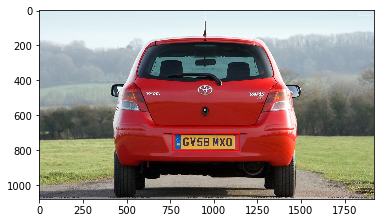

In [5]:
def get_bounding_box(bbox):
    return int(bbox[0]*image.shape[0]),int(bbox[1]*image.shape[1]),\
    int(bbox[2]*image.shape[0]),int(bbox[3]*image.shape[1])
    
def to_gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    return cv2.medianBlur(gray, 3)

ymin, xmin, ymax, xmax = get_bounding_box(boxes[0,0,:])
copied = np.copy(rgb_image)
cv2.rectangle(copied,(xmin,ymin),(xmax,ymax),(255,0,0),5)
plt.imshow(copied)
plt.show()

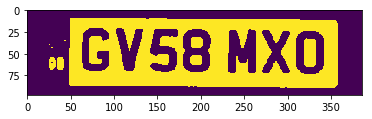

In [6]:
cropped = image[ymin:ymax,xmin:xmax]
plt.imshow(to_gray(cropped))
plt.show()